<a href="https://colab.research.google.com/github/maddym132/prophet_anomaly_detection/blob/master/FBprophet_Anomaly-detection_madan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fbprophet import Prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


The dataset is straightforward and contains only two columns as timestamp and count of taxi trips, and there is a timestamp for every half-hour interval. The data spans over seven months, from July 2014 to Jan 2015. The target is to predict how many taxis were active daily or on half an hour basis in new york city. 

In [3]:
df = pd.read_csv("/content/nyc_taxi.csv")
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [4]:
df.dtypes

timestamp    object
value         int64
dtype: object

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:

df.dtypes

timestamp    datetime64[ns]
value                 int64
dtype: object

to visualize it quickly, I am resampling the data hourly. By keeping timestamp as an index, we are resampling it on an hourly basis from half an hour and taking its mean. It will not disturb the data distribution because it takes 2 values and finds its mean.

In [7]:
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.shape

(5160, 2)

Now we are going to plot the data, and I am drawing the line chart. On the x-axis, we have a timestamp, and on Y-axis, we have values.

In [8]:
#express to plot entire data
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward")
        ])
    )
)
fig.show()

## modeling
 using Facebook Prophet to detect anomalies in time-series data

In [9]:
from fbprophet import Prophet
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

Separate the train and test set

In [10]:
#train test split
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds'] > '2015-01-27')]

From 2014 July to 27th January 2015, we have taken in the train set and remain in the test set.

Create Prophet model

When we use Facebook prophet, it gives the output according to the confidence interval. By default, it is set to 80 per cent, and we change it to a 95 per cent confidence interval so it will give us prediction and lower and upper confidence intervals. After that, we feed the train data to it. After running the below snippet, it shows you that yearly seasonality is not valid because data is of only six months.

In [11]:
m = Prophet(changepoint_range=0.95)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Forecast on test data

We are creating a dataframe that only consists of dates of test data in timestamp format to forecast test data. We need to create a dataframe with hourly frequency because by default it creates on daily basis.

In [12]:
future = m.make_future_dataframe(periods=119, freq='H')

In [13]:
future.tail()

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


Now we will predict the target value on these dates. you can see that that is the predicted value, that lower is the lower confidence interval and the upper column represent the upper confidence interval.

In [14]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19342.631378,28550.354559
5156,2015-01-31 20:00:00,24342.584334,19639.224682,29113.590889
5157,2015-01-31 21:00:00,23219.297735,18705.181706,28031.689190
5158,2015-01-31 22:00:00,21027.355314,15805.817053,25805.553833
5159,2015-01-31 23:00:00,18500.216845,13595.244390,22910.542773


Now we want to see the difference between actual and predicted values so I am creating a new dataframe where we merge the actual and forecasted dataframe. At the same time, we also visualize the forecast values to understand the predictions.

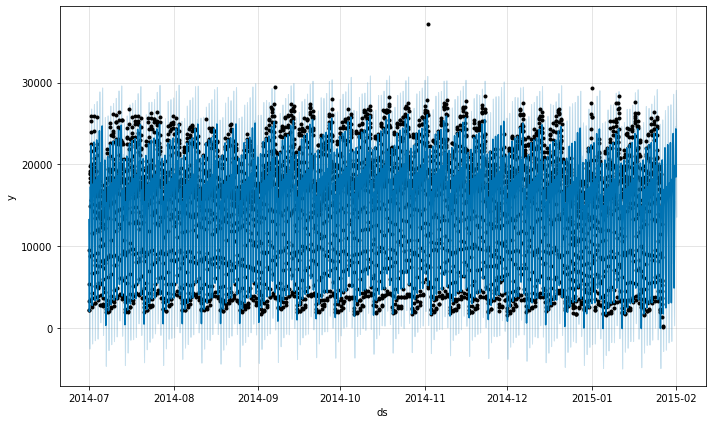

In [15]:
result = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

The black points are the actual outcomes(target), dark blue points are the predicted points. upper light blue shades represent the upper confidence interval and lower shades represent the lower confidence interval. Still, we have not done anything with outliers but some points we can see as outliers which we will deal with in the next section.

We will also plot the component of time series data. what these components will give? It will take the time-series data and give the trend and seasonality component out of it.

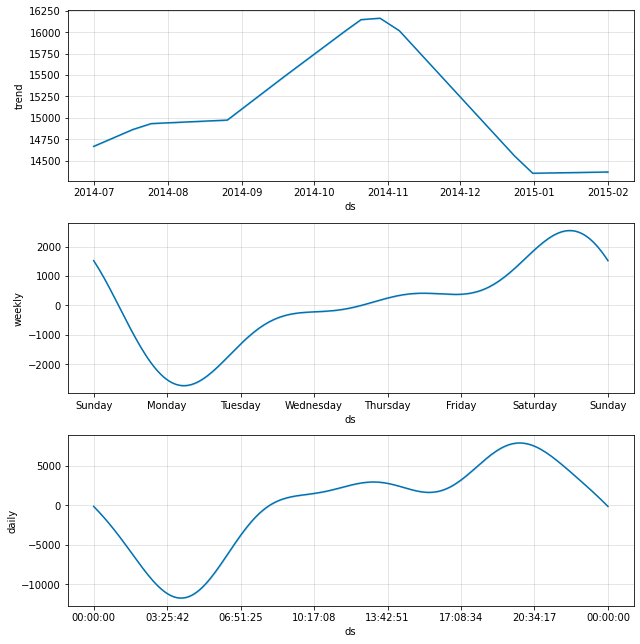

In [16]:
comp = m.plot_components(forecast)

The top one is a trend. Data from 2014 July has an increasing trend and then it has a decreasing trend.
The second plot shows the weekly trend then the number of rides running in a new york city decrease at Sunday time and starts increasing from Monday. Basically, on Sunday everyone usually takes holiday and from Monday offices are about to start.
The third plot is about the daily pattern which shows the 24 hours window. the number of rides is slower from midnight to morning 4’O clock and then increases till 8 pm and then reduces to some extent.
why this component’s visualization is important? The reason is when I spoke about contextual outliers then it will take a weekly and daily seasonality into consideration while modelling so that it can detect outliers that look like inliers.

Anomaly and outlier detection

First, we are adding two columns to the result dataframe. error is a difference between actual and predicted values. The second is uncertainty level which is the difference between upper and lower confidence interval

In [17]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

The error can be negative or positive so we are taking absolute of it and checking that is it greater than the uncertainty level then most probably it is an outlier or an incident that is most likely to outperform in a dataset from a normal distribution. And these points or records we will get it will be assigned as an anomaly in the data.

In [18]:
result[result['error'].abs() > 1.5 * result['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9248.209868,19040.242014,22985.607130,9792.032147
2015-01-01 01:00:00,29292.0,11405.545567,6787.152455,16018.692722,17886.454433,9231.540267
2015-01-01 02:00:00,25753.5,7770.054639,3028.340271,12269.208599,17983.445361,9240.868328
2015-01-01 03:00:00,22067.0,4478.895177,-376.313202,9440.045153,17588.104823,9816.358355
2015-01-26 19:00:00,4565.5,19771.308307,14844.684515,24546.237764,-15205.808307,9701.553249
2015-01-26 20:00:00,3630.5,20546.581743,16054.779687,25499.527774,-16916.081743,9444.748087
2015-01-26 21:00:00,2907.0,19647.710004,15265.319227,24549.125606,-16740.710004,9283.806378
2015-01-26 22:00:00,1324.5,17691.969234,12968.567717,22488.912048,-16367.469234,9520.344331
2015-01-26 23:00:00,243.0,15411.348672,10592.994221,19840.633767,-15168.348672,9247.639546


Among 5160 rows only a few are detected as an anomaly. let us see it in brief. The first record on 2nd November 2014 in new york is a marathon so most likely people around different cities come to become a part of it and enjoy it. After that we can see on 1st January it is new year eve so all the normal plots we have seen upper are reverse on this dates because as we saw that from midnight to 4 AM in morning number of taxi are less active but on new year eve, it is completely reverse.

In [19]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
#result['anomaly'] = np.where(np.abs(x['error']) > 1.5*x['uncertainty']), 'Yes', 'No') 

Visualizing the Anomalies in Data

Now we are creating a scatter plot in which the x-axis is a timestamp, the y-axis values, and color of points vary as per anomaly. the color is the anomaly part of it so let us see that how anomalies look in a graph.

In [20]:
#visualize the anomaly data
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')
#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()